# Dereverb - DAAP Project

Students: 

*   Federico Maver ( ID: 10565151, MATR: 952840 )
*   Filippo Gualtieri ( ID: , MATR: 953546 )

Import libraries:

In [158]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa, librosa.display
import pyroomacoustics as pra
import acoustics as ac
import scipy.signal as signal
from scipy.io import wavfile
import IPython.display as ipd
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import soundfile as sf

### Part 1: RIR and reverberation
From the image we can see that values of beta should be chosen between 0.2 for small rooms (4 m per side) and 1.8 for very big rooms (30 m per side);

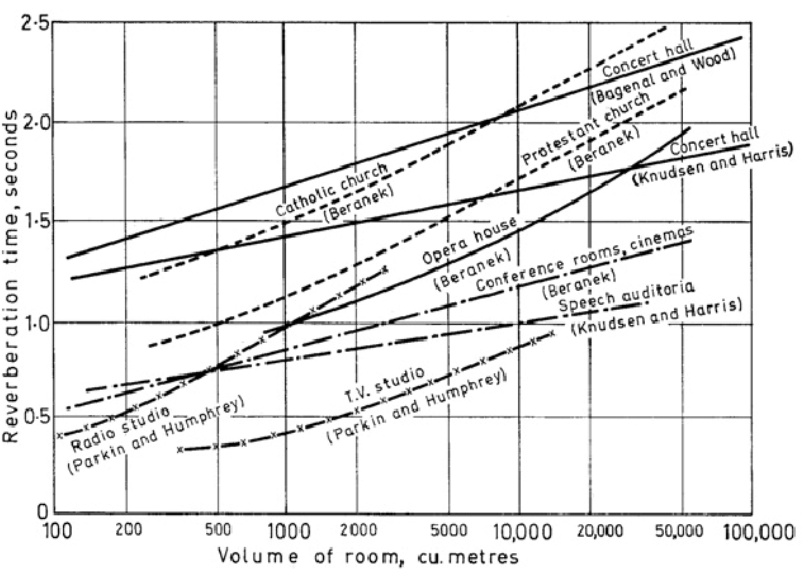

In [159]:
ipd.Image(filename = "images/RevTime1.png", width = 600, height = 300)

Let's define some parameters:

In [160]:
fs = 22500 # sampling rate (Hz)

rt60_tgt = 1  # reverberation time (s)
room_dim = [10, 7.5, 3.5]  # room dimensions (m)

source_pos = [5, 1, 1] # x, y, z position of the source (m)
mic_locs = np.c_[ [4.7, 5, 1.2], [5.3, 5, 1.2] ] # location of the microphone / microphone array (m)

Visualization of the room with source and mics:

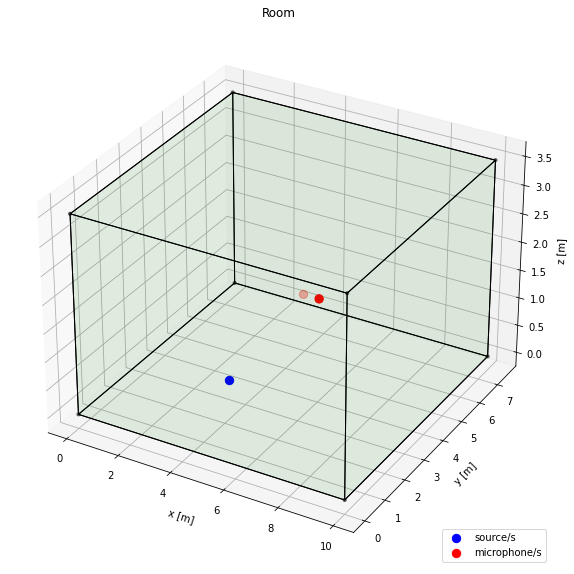

In [161]:
# vertices of the room
v = np.array([[0, 0, 0], [room_dim[0], 0, 0], [room_dim[0], room_dim[1], 0], [0, room_dim[1], 0], [0, 0, room_dim[2]], [room_dim[0], 0, room_dim[2]], [room_dim[0], room_dim[1], room_dim[2]], [0, room_dim[1], room_dim[2]]])

# room, sources and mics plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(source_pos[0], source_pos[1], source_pos[2], c='b', s=70)
ax.scatter(mic_locs[0, :], mic_locs[1, :], mic_locs[2, :], c='r', s=70)

ax.scatter3D(v[:, 0], v[:, 1], v[:, 2], s=10, c='k', alpha=0.5)

# generate list of sides' polygons of our room
walls = [ [v[0],v[1],v[2],v[3]], [v[4],v[5],v[6],v[7]], [v[2],v[3],v[7],v[6]], [v[0],v[3],v[7],v[4]], [v[0],v[1],v[5],v[4]], [v[1],v[2],v[6],v[5]] ]

# plot sides
ax.add_collection3d(Poly3DCollection(walls, facecolors='green', linewidths=1, edgecolors='k', alpha=0.05))

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Room')
ax.legend(('source/s','microphone/s'), loc='lower right', frameon=True);

Now generate the RIR and apply it to the audio files

In [162]:
# import a mono wavfile as the source signal: the sampling frequency should match that of the room
# audio/OSR_us_000_0010_8k.wav

audio, fs = librosa.load('audio/AudioSamples/Voice_ChangeHasComeToAmerica.wav', sr=fs)
#audio=audio[:5*fs]

In [163]:
# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)

# Create the room
room = pra.ShoeBox(room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order);

# volume of the room
print("The volume of the room is {} m\u00b3".format(room.get_volume()))

The volume of the room is 262.5 m³


In [164]:
# place the source in the room
room.add_source(source_pos, signal=audio); #delay=0.5

# place the microphone array in the room
room.add_microphone_array(mic_locs);

In [165]:
# Run the simulation (this will also build the RIR automatically)
room.simulate()

# Save the reverberated audio into a file
room.mic_array.to_wav(
    f"audio/generated/voiced_aREV.wav",
    norm=True,
    bitdepth=np.int16,
)

x_rev = room.mic_array.signals[0, :];

global_delay = pra.constants.get("frac_delay_length") // 2

print('Global delay introduced by the simulation:', global_delay)

# measure the reverberation time
rt60 = room.measure_rt60()
print("The desired RT60 was {} s".format(rt60_tgt))
print("The measured RT60 is {} s".format(rt60[0, 0]))

Global delay introduced by the simulation: 40
The desired RT60 was 1 s
The measured RT60 is 1.6926666666666668 s


*Do we need to take into account the global delay when computing filters?*

Original signal: (56816,)
RIR: (2, 1, 70947)
Reverberated signal: (127762,)


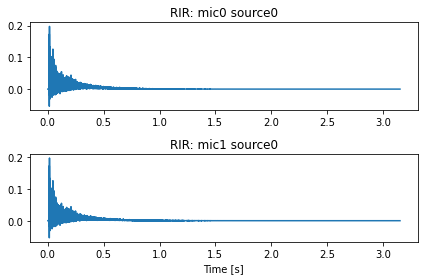

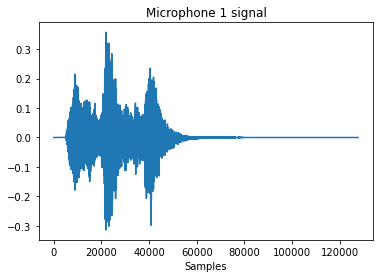

In [166]:
# Plot the RIRs
room.plot_rir()

plt.figure()
# plot signal at microphone 1
plt.plot(room.mic_array.signals[0, :])
plt.title("Microphone 1 signal")
plt.xlabel("Samples");


print('Original signal:', audio.shape)
print('RIR:', np.array(room.rir).shape )
print('Reverberated signal:', np.array(room.mic_array.signals[0, :]).shape)

In [167]:
# save RIR into a wav
# sf.write('audio/RIR.wav', np.array(np.squeeze(room.rir)), samplerate=fs)

#### Audio files
Dry signal:

In [168]:
ipd.display(ipd.Audio(audio, rate=fs))

Reverberated signal:

In [169]:
ipd.display(ipd.Audio(room.mic_array.signals[0, :], rate=fs))

###COMPLEX CEPSTRUM 
we try to define our oun function since the acoustic one seems to not behave correctly



In [170]:
def _unwrap(phase):
        samples = phase.shape[-1]
        unwrapped = np.unwrap(phase)
        center = (samples + 1) // 2
        if samples == 1:
            center = 0
        ndelay = np.array(np.round(unwrapped[..., center] / np.pi))
        unwrapped -= np.pi * ndelay[..., None] * np.arange(samples) / center
        return unwrapped, ndelay

     
   


### Estimation of h:
*  Window the signal in a series of frames
*  Compute complex cepstrum of each frame
*  Estimate $\hat{h}_{est}$ as:
$$\hat{h}_{est}(q,\tau)=\frac{1}{L}\cdot\sum\limits_{l=\tau}^{\tau+L-1}\hat{x}(q,l)$$

(127762,)
(4, 32768)
-2210.75


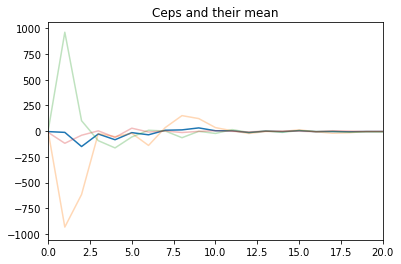

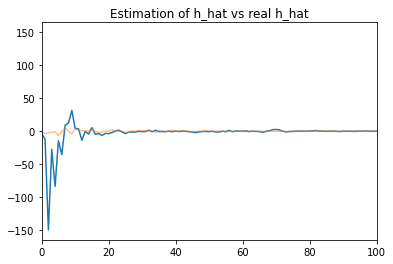

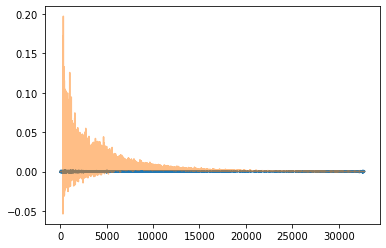

In [224]:
# N frames, non overlap per evitare correlazione

N_length = 32768

N_frames = int(np.floor(len(x_rev)/N_length)+1)

# print(N_frames, len(x_rev), N_length*N_frames)

pad_length = int(N_length*N_frames)-len(x_rev)

x_rev_pad = np.pad(x_rev, (0,pad_length))
# print(padded_length-len(x_rev), x_rev_pad.shape)

frame_list = []

for i in range(N_frames):
    frame_list.append(x_rev_pad[i*N_length:(i+1)*N_length])


print(x_rev.shape)
cepstra, ndelay = ac.cepstrum.complex_cepstrum(frame_list, N_length)

#cepstratest, ndelaytest = ac.cepstrum.complex_cepstrum(frame_list[0], N_length)

#plt.figure(figsize=(15,20))
#plt.title("test funzionamento con lista")
#plt.xlim([0,100])
#plt.plot(cepstra[0])
#plt.plot(cepstratest, alpha=0.6)
#cepstra = np.array(cepstra)
print(np.array(cepstra).shape)

# h_est vs h nel cepstrum domain
h_hat_est = np.mean(cepstra, 0)
ndelay_mean = np.mean(ndelay)
plt.figure()
plt.title("Ceps and their mean")
plt.plot(h_hat_est)
plt.plot(cepstra[0], alpha=0.3)
plt.plot(cepstra[1], alpha=0.3)
plt.plot(cepstra[3], alpha=0.3)
plt.xlim([0,20])


plt.figure()

plt.plot(h_hat_est)
plt.title("Estimation of h_hat vs real h_hat")
plt.xlim([0,100])
hprova = np.squeeze(np.array(room.rir[0]))
hprovaceps = ac.cepstrum.complex_cepstrum(hprova, N_length)
plt.plot(hprovaceps[0], alpha=0.5)

# stima di h vs h_est
print(ndelay_mean)
h_est = ac.cepstrum.inverse_complex_cepstrum(h_hat_est, ndelay_mean)

hprovacepsinv = ac.cepstrum.inverse_complex_cepstrum(hprovaceps[0],hprovaceps[1]) 

plt.figure()
plt.plot(h_est)
plt.plot(hprovacepsinv, alpha=0.5)

### Avoid cross-talking between frames:
Segment the signal and use only speech parts in order to compute $h_{est}$

### Minimum-Phase/Allpass Decomposition: Standard Approach

**NOTATION:**
*  k = time sample
*  K = number of time samples
*  n = frequency bin
*  N = number of frequency bins

In [172]:
# select the largest number so that signals are all the same length
# longest signal is given by the reverberated signal

sig_length = len(x_rev)
N_samples = int(pow(2, np.ceil(np.log(sig_length)/np.log(2))))

K = N_samples

print('Length of the signal:', sig_length)
print('Next power of 2:', N_samples)

Length of the signal: 127762
Next power of 2: 131072


1. Compute the discrete Fourier transform (DFT) of \\(h(k)\\), or \\(H(n)\\)

In [173]:
h = np.squeeze(np.array(room.rir))[0]

h = [hprovacepsinv,1]
#h = [h_est,1]
# h = librosa.load('audio/1st-baptist-nashville/stereo/1st_baptist_nashville_far_wide.wav', sr=fs)
# x_rev = np.convolve(audio,h[0])
H = np.fft.fft(h[0], n=K)

print('RIR shape:', h[0].shape)
print('RIR DFT shape:', H.shape)

RIR shape: (32768,)
RIR DFT shape: (131072,)


2. Compute the logarithm of the frequency response, as \\(\hat{H}(n) = \log|H(n)| + j\arg(H(n))\\)

In [174]:
# step 2

H_amp_log = np.log(np.abs(H))
H_phase = np.angle(H) # phase unwrap?!
H_phase,_=_unwrap(H_phase)
H_hat = H_amp_log + 1j*H_phase

N = len(H)
k = np.arange(0,N)
print('Time vector k:', k)
print('N frequency bins:', N)
# plt.plot(H_amp_log);

Time vector k: [     0      1      2 ... 131069 131070 131071]
N frequency bins: 131072


3. Compute the even part of the complex cepstrum as: \\[\hat{h}_e(k) = \frac{1}{N}\sum_{n=0}^{N-1} \log|H(n)|e^{j(2\pi/N)kn} \\] where \\(k = 0,1,2,...,N-1\\)

In [175]:
h_e_hat = np.fft.ifft(H_amp_log)

print('Size of even part of complex cepstrum:', h_e_hat.shape)

Size of even part of complex cepstrum: (131072,)


4. Calculate the corresponding complex cepstrum of the minimum phase sequence: \\[\hat{h}_{mp}(k) = \begin{cases} \hat{h}_e(k), & k=0,N/2 \\ 2\hat{h}_e(k), & 1\leq k < N/2\\ 0, & N/2 < k \leq N-1 \end{cases} \\]

In [176]:
h_e_hat = np.squeeze(h_e_hat)

h_mp_hat = np.zeros(N, dtype=np.complex)

h_mp_hat[1:int(N/2)] = 2*h_e_hat[1:int(N/2)]
h_mp_hat[0] =  h_e_hat[0]
h_mp_hat[int(N/2)] =  h_e_hat[int(N/2)]

print('Example 1:', h_mp_hat[int(N/2)])
print('Example 2:', h_mp_hat[int(N/4)])
print('Example 3:', h_mp_hat[int(N-1)])

Example 1: (0.0001046868503719045+0j)
Example 2: (-0.00014142468779465567+0j)
Example 3: 0j


5. Compute the DFT of \\(\hat{h}_{mp}(k)\\), as: \\[ \hat{H}_{mp}(n) = \sum_{n=0}^{N-1} \hat{h}_{mp}(k)e^{-j(2\pi/N)kn}\\]

In [177]:
H_mp_hat = np.fft.fft(h_mp_hat, n=K)

# fig = plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.plot(np.abs(H_mp_hat));
# plt.subplot(1,2,2)
# plt.plot(np.angle(H_mp_hat));

6. Infer the minimum phase part of \\(H(n)\\), as \\(H_{mp}(n) = exp[\hat{H}_{mp}(n)]\\)

In [178]:
# step 6
H_mp = np.exp(H_mp_hat)
H_mp = np.squeeze(H_mp)

# fig = plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.plot(np.abs(H_mp));
# plt.subplot(1,2,2)
# plt.plot(np.angle(H_mp));

Now that \\(H_{mp}(n)\\) is known, the remaining allpass component can be computed as \\(H_{ap}(n)= H(n)G_{mp}(n)\\), where \\(G_{mp}(n)=1/H_{mp}(n)\\) is the minimum phase inverse.

In [179]:
# minimum phase inverse
G_mp = 1/H_mp
#G_mp = np.squeeze(G_mp)

print(G_mp.shape)

# fig = plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.plot(np.abs(G_mp));
# plt.subplot(1,2,2)
# plt.plot(np.angle(G_mp));

(131072,)


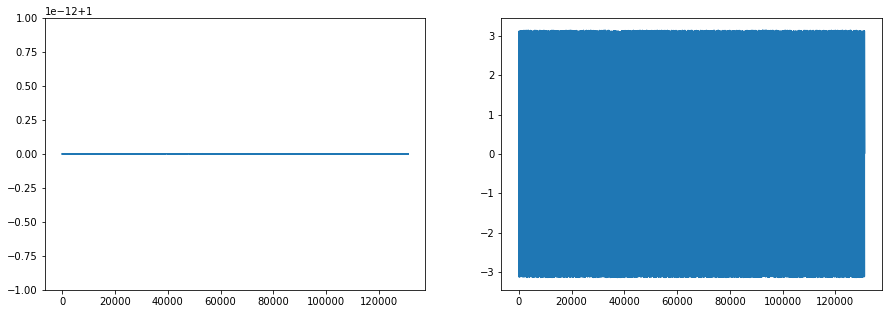

In [180]:
# allpass component
H_ap = H*G_mp

fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.abs(H_ap));
plt.subplot(1,2,2)
plt.plot(np.angle(H_ap));

C:\Users\filip\miniconda3\envs\SASP\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


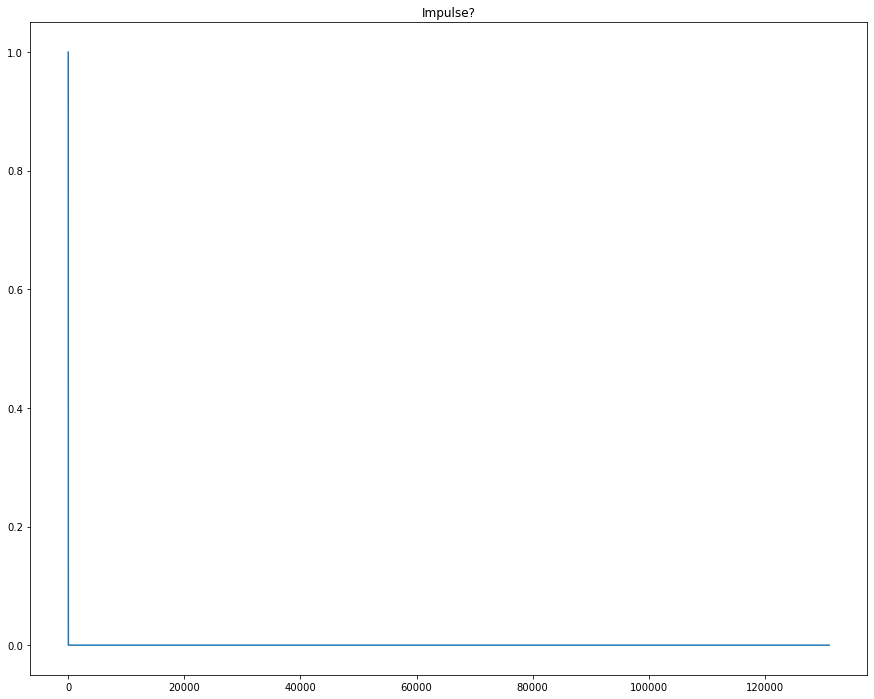

In [181]:
imp = np.fft.ifft(H_ap*np.conj(H_ap))

plt.figure(figsize=(15,12))
plt.title("Impulse?")
plt.plot(imp)

Apply to signal and see the result:

In [182]:
# dry DFT:
X_dry = np.fft.fft(audio, n=N)

# fig = plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.plot(np.abs(X_dry));
# plt.subplot(1,2,2)
# plt.plot(np.angle(X_dry));

In [183]:
X_rev = np.fft.fft(x_rev, n=K)

# filter dry signal to obtain reverberated one
X_dry_rec= X_rev / (H_mp*H_ap)

# fig = plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.plot(np.abs(X_rev));
# plt.subplot(1,2,2)
# plt.plot(np.angle(X_rev));

C:\Users\filip\miniconda3\envs\SASP\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\filip\miniconda3\envs\SASP\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\filip\miniconda3\envs\SASP\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


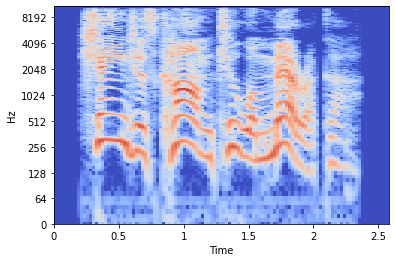

In [184]:
Y = librosa.stft(audio)
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(Y)),y_axis='log', x_axis='time', ax=ax);

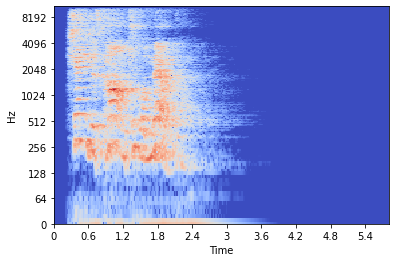

In [185]:
Y = librosa.stft(x_rev)
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(Y)),y_axis='log', x_axis='time', ax=ax);

In [186]:
# derverb audio file
x_dry_rec = np.fft.ifft(X_dry_rec)
x_dry_rec = np.real(x_dry_rec)

In [187]:
# sf.write('audio/try.wav', x_dry_rec, samplerate=fs)

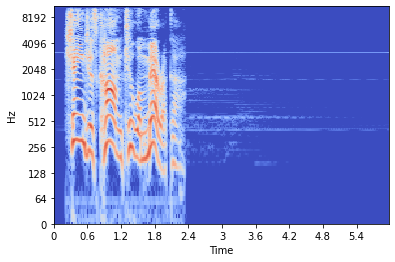

In [188]:
Y = librosa.stft(x_dry_rec)
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(Y)),y_axis='log', x_axis='time', ax=ax);

#### Audio files comparison

In [189]:
# dry
ipd.display(ipd.Audio(audio, rate=fs, normalize=True)) 
# wet
ipd.display(ipd.Audio(x_rev, rate=fs, normalize=True))
# filtered: reverberated
ipd.display(ipd.Audio(x_dry_rec, rate=fs, normalize=True))

#### RIR Comparison (Standard Approach)

In [190]:
h_mp=np.fft.ifft(H_mp)
g_mp=np.fft.ifft(G_mp)
# h_ap=np.convolve(h,g_mp)
# h_rec=np.convolve(h_mp,h_ap)
# h_rec_freqs=np.fft.ifft(H_ap*H_mp)

# plt.figure(figsize=(15,4))
# plt.subplot(1,3,1)
# plt.title("Reconstructed RIR computed in time domain")
# plt.xlim([0,len(h)])
# plt.plot(np.real(h_rec))
# plt.subplot(1,3,2)
# plt.title("Reconstructed RIR computed in frequency domain")
# plt.plot(np.real(h_rec_freqs))
# plt.xlim([0,len(h)])
# plt.subplot(1,3,3)
# plt.title("Original RIR in time domain")
# plt.plot(np.real(h))
# plt.xlim([0,len(h)])
# plt.show()

### Minimum-Phase/Allpass Decomposition: Novel Approach

In [191]:
# parameters:
L = 4

1. Calculate $H(n)$, $\hat{H}(n)$, $\hat{h}_{e}(k)$, as we already did before.

2. Calculate the corresponding complex cepstrum of the minimum phase sequence: $$\hat{h}_{mp}^{1/L}(k) = \begin{cases} \hat{h}_e(k)/L, & k=0,N/2 \\ 2\hat{h}_e(k)/L, & 1\leq k < N/2\\ 0, & N/2 < k \leq N-1 \end{cases} $$

In [192]:
h_mp_hat_L = np.zeros(N, dtype=np.complex)

h_mp_hat_L[1:int(N/2)] = 2*h_e_hat[1:int(N/2)]/L
h_mp_hat_L[0] = h_e_hat[0]
h_mp_hat_L[int(N/2)] = h_e_hat[int(N/2)]/L

3. Compute the DFT of $\hat{h}_{mp}^{1/L}(k)$, $\hat{H}_{mp}^{1/L}(k)$

In [193]:
H_mp_hat_L=np.fft.fft(h_mp_hat_L)

4. Infer the minimum phase part $H_{mp}^{1/L}(k)$, as the exponential function of $\hat{H}_{mp}^{1/L}(k)$

In [194]:
H_mp_L=np.exp(H_mp_hat_L)

print(H_mp_L.shape)

(131072,)


5. Calculate the frequency response $H^{(l+1)}(n)$, as: $$H^{(l+1)}(n)= \frac{H^{(l)}(n)}{H^{1/L}_{mp}(n)}$$

where $H^{(l+1)}(n)$ denotes the partly equalized room transfer function resulting from the $(l+1)^{th}$ stage of computation $(l = 0,1,. . . , L-1)$,
and $H^{(0)}(n) = H(n)$

In [195]:
H_iter = H

for l in range(L):
    H_iter=H_iter/H_mp_L
    
H_ap = H_iter

In [196]:
# time domain response function

# h_iter = h
g_mp_L = np.fft.ifft((1/H_mp_L))

# for l in tqdm(range(L)):
#     h_iter = np.convolve(h_iter, g_mp_L)

# h_ap = h_iter

In [197]:
H_novel = H_ap*(H_mp_L**L)

In [198]:
X_dry_rec_novel= X_rev / H_novel

# derverb audio file
x_dry_rec_novel = np.fft.ifft(X_dry_rec_novel)
x_dry_rec_novel = np.real(x_dry_rec_novel)

In [199]:
# dry
ipd.display(ipd.Audio(audio, rate=fs, normalize=True))
# wet
ipd.display(ipd.Audio(x_rev, rate=fs, normalize=True))
# filtered: reverberated
ipd.display(ipd.Audio(x_dry_rec_novel, rate=fs, normalize=True))

### Graph comparison:

Figure 1:

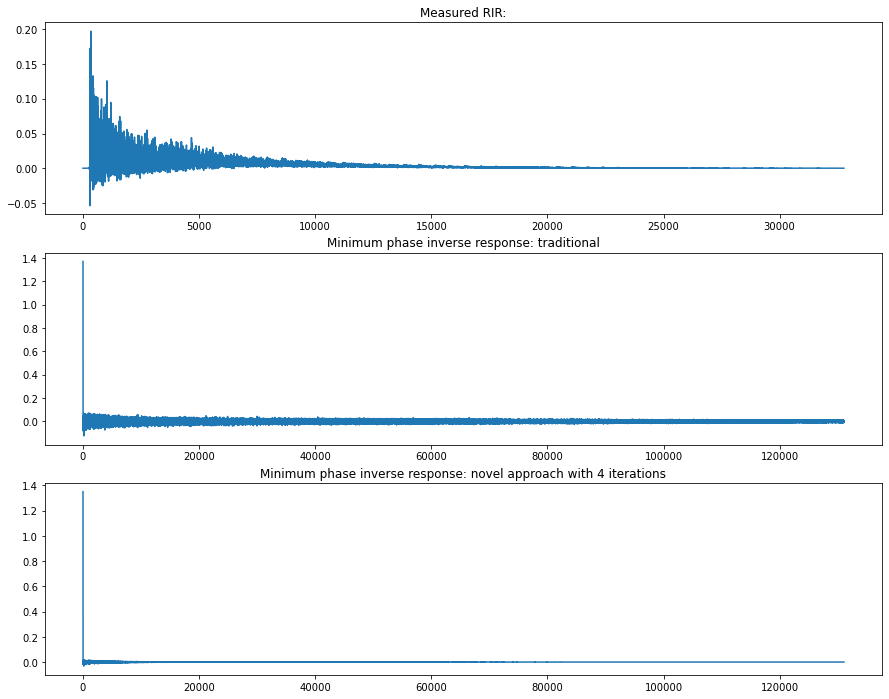

In [200]:
plt.figure(figsize=(15,12))
plt.subplot(3,1,1)
plt.title("Measured RIR:")
plt.plot(h[0])
# plt.xlim([0,len(h)])
# plt.ylim([-0.5,0.5])

plt.subplot(3,1,2)
plt.title("Minimum phase inverse response: traditional")
plt.plot(np.real(g_mp))
# plt.xlim([0,len(h)])
# plt.ylim([-0.5,0.5])

plt.subplot(3,1,3)
plt.title("Minimum phase inverse response: novel approach with {} iterations".format(L))
plt.plot(np.real(g_mp_L))
# plt.xlim([0,len(h)])
# plt.ylim([-0.5,0.5])
plt.show()

### Phase Equalization

C:\Users\filip\miniconda3\envs\SASP\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


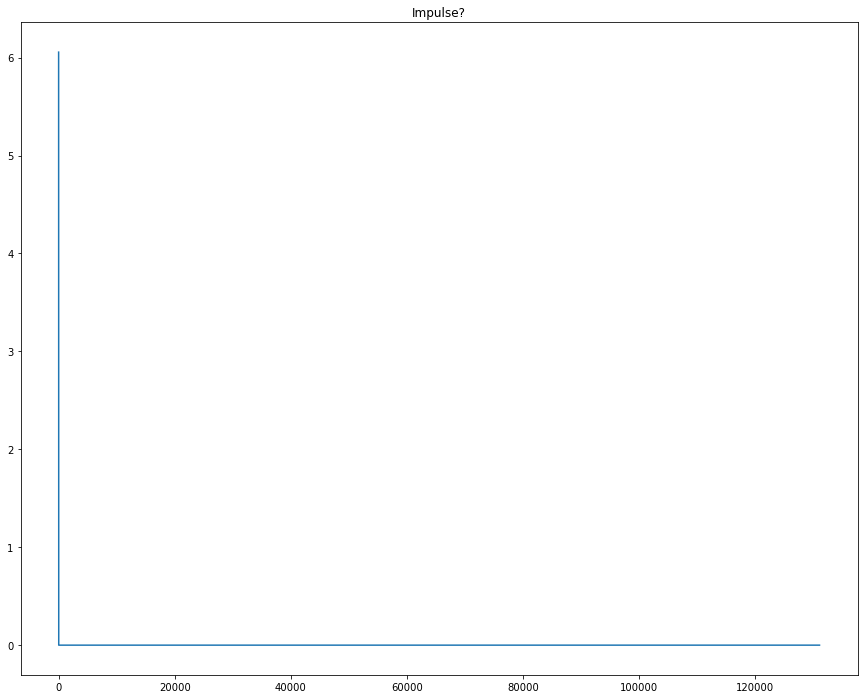

In [201]:
imp = np.fft.ifft(H_ap*np.conj(H_ap))

plt.figure(figsize=(15,12))
plt.title("Impulse?")
plt.plot(imp)